In [1]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict
import seaborn as sns
sns.set_palette("colorblind")

In [2]:
os.chdir("/home/edgan/projects/sketchstore/java")

In [3]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_truncation": "C4",
    
    "cms_min": "C5",
    "kll": "C5",
    "low_discrep": "C6",
    "yahoo_mg": "C6",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    "dyadic_truncation": "<",
    
    "cms_min": "o",
    "kll": "o",
    "low_discrep": "1",
    "yahoo_mg": "1",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Trunc",
    "pps": "PPS",
    "random_sample": "USample",
    "dyadic_truncation": "Hierarchy",

    "cms_min": "CMS",
    "kll": "KLL",
    "low_discrep": "LDisc",
    "yahoo_mg": "MG",
}
data_display_name = {
    "l_caida_f": "CAIDA",
    "l_zipf_f": "Zipf",
    "l_mnetwork_f": "Service:Provider",
    "l_mos_f": "Service:OSBuild",
    "l_power_q": "Power",
    "l_uniform_q": "Uniform",
    "l_mrecords_q": "Service:Traffic",
}
def get_error_file(experiment_name):
    return os.path.join(
        "output/results/{}".format(experiment_name),
        "errors.csv"
    )
def get_construct_file(experiment_name):
    return os.path.join(
        "output/results/{}".format(experiment_name),
        "load_time.csv"
    )

In [4]:
f_sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "truncation", 
    "pps",
    "cms_min", 
    "yahoo_mg",
]
q_sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "truncation", 
    "pps",
    "kll",
    "low_discrep",
]

# Multi Dataset

In [5]:
def query_length_plot(
    e_combined,
    sketch_names: List,
    item_agg="max",
    query_agg="mean",
    ax = None,
    absolute=False,
    vary_col="query_len"
):
    e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    if absolute:
        e_combined["e_norm"] = e_combined[item_agg]
    eg = e_combined.groupby(["sketch", vary_col]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            color=colormap[method],
            markersize=5,
            lw=.5,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

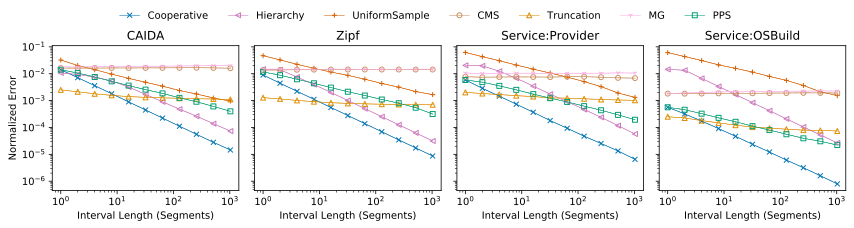

In [62]:
sketch_size = 64
experiments = [
    "l_caida_f",
    "l_zipf_f",
    "l_mnetwork_f",
    "l_mos_f",
]

fig, axs = plt.subplots(figsize=(12,3), nrows=1, ncols=4, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name in experiments:
    df = pd.read_csv(get_error_file(dataset_name))
    query_length_plot(
        df,
        f_sketch_names,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
        absolute=False,
    )
    axs[di].set_title(data_display_name[dataset_name])
    axs[di].set_xlabel("Interval Length (Segments)")
#     axs[di].yaxis.grid(lw=0.5,ls="-.")
    di += 1
    

axs[0].set_ylabel("Normalized Error")

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(2, 1.3), ncol=7)
fname = "output/plots/linear_freq.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

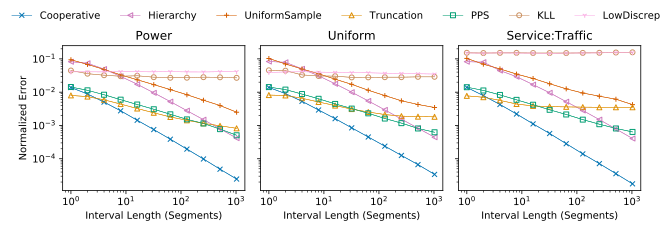

In [54]:
sketch_size = 64
experiments = [
    "l_power_q",
    "l_uniform_q",
    "l_mrecords_q",
]

fig, axs = plt.subplots(figsize=(9,3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
egs = []
for dataset_name in experiments:
    df = pd.read_csv(get_error_file(dataset_name))
    ax1, eg1 = query_length_plot(
        df,
        q_sketch_names,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
#         absolute=True
    )
    axs[di].set_title(data_display_name[dataset_name])
    axs[di].set_xlabel("Interval Length (Segments)")
#     axs[di].yaxis.grid(lw=0.5,ls="-.")
    egs.append(eg1)
    di += 1

axs[0].set_ylabel("Normalized Error")
# axs[0].set_ylim(10**-5, 1)

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.3), ncol=7)
fname = "output/plots/linear_quant.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Varying Accumulator

In [65]:
def plot_vary_acc(
    df,
    experiment_name,
    sketch_names,
    item_agg = "max",
    query_agg = "mean",
    ax = None
):
    df["e_norm"] = df[item_agg] / df["total"]

    eg = df.groupby([
        "sketch", "accumulator_size"
    ]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"]/ np.sqrt(eg["e_norm", "count"])
            
    for method in sketch_names:
        eg_cur = eg.loc[method]
        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            color=colormap[method],
            lw=.5,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )
    ax.set_xscale("log")
    ax.set_yscale("log")
    return

/home/edgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


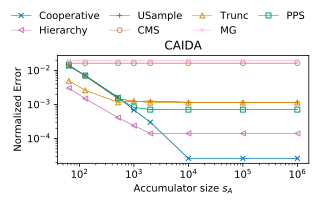

In [98]:
experiment = "l_caidaacc_f"
df = pd.read_csv(get_error_file(experiment))
df_sel = df[df["query_len"] == 512]
fig = plt.figure(figsize=(4.5,3.1))
ax = fig.gca()
plot_vary_acc(
    df_sel,
    experiment,
    f_sketch_names,
    ax=ax
)
lgd = ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(.4, 1.1), ncol=4, columnspacing=1)
ax.set_xlabel("Accumulator size $s_A$")
ax.set_ylabel("Normalized Error")
ax.set_title("CAIDA")
fig.tight_layout()
fname = "output/plots/linear_acc_f.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/edgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


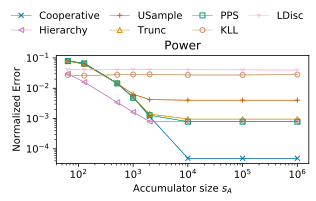

In [99]:
experiment = "l_poweracc_q"
df = pd.read_csv(get_error_file(experiment))
df_sel = df[df["query_len"] == 512]
fig = plt.figure(figsize=(4.5,3.1))
ax = fig.gca()
plot_vary_acc(
    df_sel,
    experiment,
    q_sketch_names,
    ax=ax
)
lgd = ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(.4, 1.1), ncol=4, columnspacing=1)
ax.set_xlabel("Accumulator size $s_A$")
ax.set_ylabel("Normalized Error")
ax.set_title("Power")
fig.tight_layout()
fname = "output/plots/linear_acc_q.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Varying Space

/home/edgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


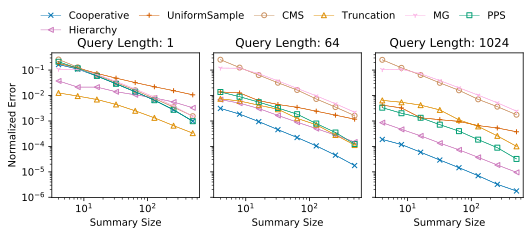

In [73]:
dataset_name = "l_caidasize_f"
query_lengths = [1, 64, 1024]
df_tot = pd.read_csv(get_error_file(dataset_name))

fig, axs = plt.subplots(figsize=(7.5,3.0), nrows=1, ncols=3, sharey=True, dpi=100)

di = 0
for query_len in query_lengths:
    df = df_tot[df_tot["query_len"] == query_len]
    query_length_plot(
        df,
        f_sketch_names,
        ax=axs[di],
        vary_col="size"
    )
    axs[di].set_title("Query Length: {}".format(query_len))
    axs[di].set_xlabel("Summary Size")
    di += 1


axs[0].set_ylabel("Normalized Error")

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.35), ncol=6, columnspacing=1)
fname = "output/plots/linear_freq_size.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Number of Segments

In [9]:
enames = [
    "l_caida_f",
    "l_caidaseg1_f",
    "l_caidaseg2_f",
    "l_caidaseg3_f"
]
dfs = [
    pd.read_csv(get_error_file(en))
    for en in enames
]
df = pd.concat(dfs).reset_index(drop=True)
df["adj_query_len"] = df["granularity"] / df["query_len"]
df_sel = df[df["adj_query_len"] == 4.0]

/home/edgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


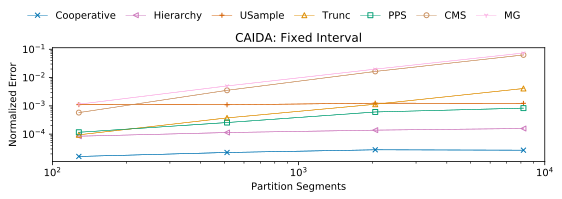

In [14]:
fig = plt.figure(figsize=(8,3.3))
ax=fig.gca()
_ = query_length_plot(
    df_sel,
    f_sketch_names,
    ax=ax,
    vary_col="granularity"
)
ax.set_xlim(100,10**4)
ax.set_xlabel("Partition Segments")
ax.set_ylabel("Normalized Error")
ax.set_title("CAIDA: Fixed Interval")
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.45, 1.4), ncol=7, columnspacing=1)
fig.tight_layout()

fname = "output/plots/linear_freq_nseg.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Query Time

In [6]:
def query_time_plot(
    e_combined,
    sketch_names: List,
    ax = None,
):
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "query_time": ["mean", "std", "max", "count"],
    })
    eg["time"] = eg[("query_time", "mean")]
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.plot(
            eg_cur.index,
            eg_cur["time"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

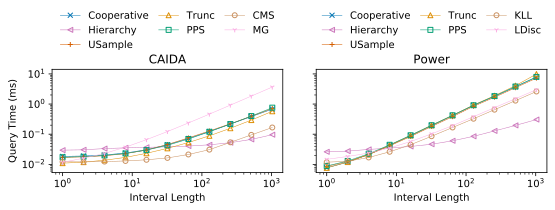

In [17]:
dataset_names = [
    "l_caida_f",
    "l_power_q",
]
dfs = [pd.read_csv(get_error_file(dname)) for dname in dataset_names]
sketch_names = [
    f_sketch_names,
    q_sketch_names
]

fig, axs = plt.subplots(figsize=(8,3.2), nrows=1, ncols=2, sharey=True, dpi=100)
lgds = []
for di in range(len(dataset_names)):
    dataset_name = dataset_names[di]
    df = dfs[di]
    ax = axs[di]
    query_time_plot(
        df,
        sketch_names[di],
        ax=ax
    )
    ax.set_xlabel("Interval Length")
    ax.set_title("{}".format(data_display_name[dataset_name]))
    lgds.append(axs[di].legend(
        frameon=False, loc='lower center', bbox_to_anchor=(.5, 1.1), ncol=3, columnspacing=1
    ))
axs[0].set_ylabel("Query Time (ms)")

fig.tight_layout()

fname = "output/plots/linear_query_time.pdf"
fig.savefig(fname, bbox_extra_artists=lgds, bbox_inches='tight')

# Construction Time

In [18]:
datasets = [
    "l_caida_f",
    "l_power_q",
]
dfs = []
for dataset in datasets:
    cur_df = pd.read_csv(get_construct_file(dataset))
    cur_df["dataset"] = dataset
    dfs.append(cur_df)
df = pd.concat(dfs)
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "truncation", 
    "pps",
    "cms_min", 
    "yahoo_mg",
    "kll",
    "low_discrep"
]
df_out = df.set_index(
    ["dataset", "sketch"])[["construct_time"]].unstack(
    ["sketch"]
)["construct_time"][sketch_names].loc[datasets]
df_out

sketch,cooperative,dyadic_truncation,random_sample,truncation,pps,cms_min,yahoo_mg,kll,low_discrep
dataset,,,,,,,,,
l_caida_f,827.266644,2741.396723,521.187554,564.266551,478.564695,587.624927,643.908017,NaN,NaN
l_power_q,613.586352,990.180781,120.072233,93.214077,98.180014,NaN,NaN,87.523877,97.633632


In [128]:
print(df_out.to_latex(
    float_format="%.1f"
))

\begin{tabular}{lrrrrrrrrr}
\toprule
sketch &  cooperative &  dyadic\_truncation &  random\_sample &  truncation &   pps &  cms\_min &  yahoo\_mg &  kll &  low\_discrep \\
dataset   &              &                    &                &             &       &          &           &      &              \\
\midrule
l\_caida\_f &       1687.8 &             8168.0 &          668.9 &       883.0 & 539.6 &    812.4 &     556.6 &  NaN &          NaN \\
l\_power\_q &        601.8 &             1009.6 &          117.5 &        93.9 &  94.6 &      NaN &       NaN & 93.8 &        102.4 \\
\bottomrule
\end{tabular}

